## Objective: Develop a machine learning model to predict customer churn based on historical customer data.

## Importing dataset 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Importing data
customers_df = pd.read_excel(r"customer_churn_large_dataset.xlsx")

In [3]:
customers_df.head(5)

CustomerID        Name  Age  Gender     Location  \
0           1  Customer_1   63    Male  Los Angeles   
1           2  Customer_2   62  Female     New York   
2           3  Customer_3   24  Female  Los Angeles   
3           4  Customer_4   36  Female        Miami   
4           5  Customer_5   46  Female        Miami   

   Subscription_Length_Months  Monthly_Bill  Total_Usage_GB  Churn  
0                          17         73.36             236      0  
1                           1         48.76             172      0  
2                           5         85.47             460      0  
3                           3         97.94             297      1  
4                          19         58.14             266      0

In [4]:
# droppig customerID and Name column as it has no significance in the model building
columns_to_drop = ['CustomerID', 'Name']
customers_df.drop(columns=columns_to_drop, axis=1, inplace=True)

In [5]:
customers_df.head(5)

Age  Gender     Location  Subscription_Length_Months  Monthly_Bill  \
0   63    Male  Los Angeles                          17         73.36   
1   62  Female     New York                           1         48.76   
2   24  Female  Los Angeles                           5         85.47   
3   36  Female        Miami                           3         97.94   
4   46  Female        Miami                          19         58.14   

   Total_Usage_GB  Churn  
0             236      0  
1             172      0  
2             460      0  
3             297      1  
4             266      0

In [6]:
# Shape of the dataframe
customers_df.shape

(100000, 7)

In [7]:
# Checking datatypes
customers_df.dtypes

Age                             int64
Gender                         object
Location                       object
Subscription_Length_Months      int64
Monthly_Bill                  float64
Total_Usage_GB                  int64
Churn                           int64
dtype: object

In [8]:
# Checking dupliacte values
customers_df[customers_df.duplicated()]

Empty DataFrame
Columns: [Age, Gender, Location, Subscription_Length_Months, Monthly_Bill, Total_Usage_GB, Churn]
Index: []

In [9]:
# Finding Missing Values
customers_df[customers_df.isnull().any(axis=1)]

Empty DataFrame
Columns: [Age, Gender, Location, Subscription_Length_Months, Monthly_Bill, Total_Usage_GB, Churn]
Index: []

In [10]:
# Overall summary of the dataset
customers_df.describe()

Age  Subscription_Length_Months   Monthly_Bill  \
count  100000.000000               100000.000000  100000.000000   
mean       44.027020                   12.490100      65.053197   
std        15.280283                    6.926461      20.230696   
min        18.000000                    1.000000      30.000000   
25%        31.000000                    6.000000      47.540000   
50%        44.000000                   12.000000      65.010000   
75%        57.000000                   19.000000      82.640000   
max        70.000000                   24.000000     100.000000   

       Total_Usage_GB          Churn  
count   100000.000000  100000.000000  
mean       274.393650       0.497790  
std        130.463063       0.499998  
min         50.000000       0.000000  
25%        161.000000       0.000000  
50%        274.000000       0.000000  
75%        387.000000       1.000000  
max        500.000000       1.000000

# Feature engineering 

### Creating a feature which classifies weather the customer is senior or not.


In [11]:
# Define a function to classify individuals as senior citizens
def is_senior_citizen(age):
    return age >= 60

# Apply the function to create the "Senior Citizen" column
customers_df['Senior Citizen'] = customers_df['Age'].apply(is_senior_citizen)

# Print the resulting DataFrame
print(customers_df)

       Age  Gender     Location  Subscription_Length_Months  Monthly_Bill  \
0       63    Male  Los Angeles                          17         73.36   
1       62  Female     New York                           1         48.76   
2       24  Female  Los Angeles                           5         85.47   
3       36  Female        Miami                           3         97.94   
4       46  Female        Miami                          19         58.14   
...    ...     ...          ...                         ...           ...   
99995   33    Male      Houston                          23         55.13   
99996   62  Female     New York                          19         61.65   
99997   64    Male      Chicago                          17         96.11   
99998   51  Female     New York                          20         49.25   
99999   27  Female  Los Angeles                          19         76.57   

       Total_Usage_GB  Churn  Senior Citizen  
0                 236      0

In [12]:
# Encoding "Status" column to 0 and 1
customers_df['Senior Citizen'] = customers_df['Senior Citizen'].astype(int)

In [13]:
customers_df

Age  Gender     Location  Subscription_Length_Months  Monthly_Bill  \
0       63    Male  Los Angeles                          17         73.36   
1       62  Female     New York                           1         48.76   
2       24  Female  Los Angeles                           5         85.47   
3       36  Female        Miami                           3         97.94   
4       46  Female        Miami                          19         58.14   
...    ...     ...          ...                         ...           ...   
99995   33    Male      Houston                          23         55.13   
99996   62  Female     New York                          19         61.65   
99997   64    Male      Chicago                          17         96.11   
99998   51  Female     New York                          20         49.25   
99999   27  Female  Los Angeles                          19         76.57   

       Total_Usage_GB  Churn  Senior Citizen  
0                 236      0               1  
1                 172      0               1  
2                 460      0               0  
3                 297      1               0  
4                 266      0               0  
...               ...    ...             ...  
99995             226      1               0  
99996             351      0               1  
99997             251      1               1  
99998             434      1               0  
99999             173      1               0  

[100000 rows x 8 columns]

###  Creating a feature of total bill.

In [14]:
customers_df['Total_Bill'] = customers_df['Monthly_Bill'] * customers_df['Subscription_Length_Months']

In [15]:
customers_df.head(2)

Age  Gender     Location  Subscription_Length_Months  Monthly_Bill  \
0   63    Male  Los Angeles                          17         73.36   
1   62  Female     New York                           1         48.76   

   Total_Usage_GB  Churn  Senior Citizen  Total_Bill  
0             236      0               1     1247.12  
1             172      0               1       48.76

### Creating a tenure group feature from Subscription_Length_Months.

In [16]:
customers_df['Subscription_Length_Months'].value_counts().head(10)

20    4303
22    4267
1     4247
16    4229
2     4228
14    4213
7     4211
11    4200
6     4184
5     4171
Name: Subscription_Length_Months, dtype: int64

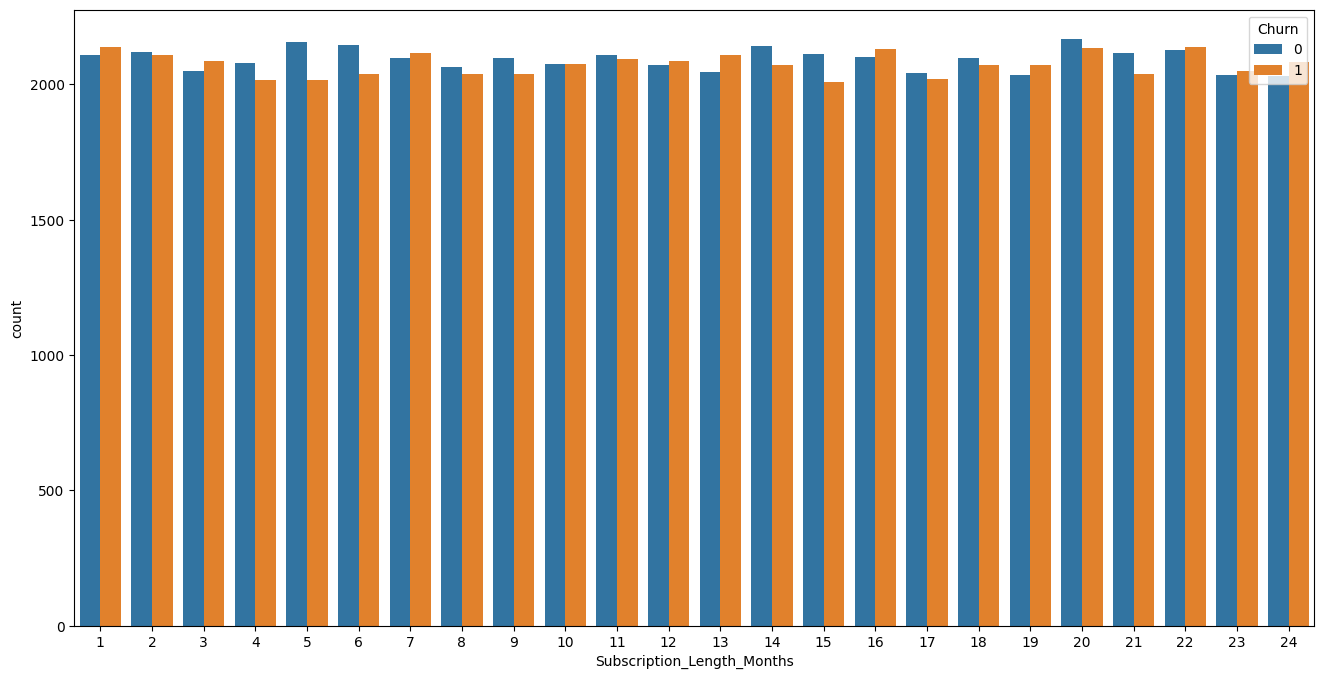

In [17]:
plt.figure(figsize=(16,8))
sns.countplot(x="Subscription_Length_Months", hue="Churn", data=customers_df)
plt.show()

In [18]:
def tenure(t):
    if t<=4:
        return 1
    elif t>4 and t<=8:
        return 2
    elif t>8 and t<=12:
        return 3
    elif t>12 and t<=16:
        return 4
    elif t>16 and t<=20:
        return 5
    else:
        return 6

customers_df["tenure_group"]=customers_df["Subscription_Length_Months"].apply(lambda x: tenure(x))

In [19]:
customers_df.head(2)

Age  Gender     Location  Subscription_Length_Months  Monthly_Bill  \
0   63    Male  Los Angeles                          17         73.36   
1   62  Female     New York                           1         48.76   

   Total_Usage_GB  Churn  Senior Citizen  Total_Bill  tenure_group  
0             236      0               1     1247.12             5  
1             172      0               1       48.76             1

### Creating a age group feature from age feature.

In [20]:
def tenure(t):
    if t<=20:
        return "young"
    elif t>20 and t<=59:
        return "adult"
    else:
        return "senior"

customers_df["age_group"]=customers_df["Age"].apply(lambda x: tenure(x))

In [21]:
customers_df.head(2)

Age  Gender     Location  Subscription_Length_Months  Monthly_Bill  \
0   63    Male  Los Angeles                          17         73.36   
1   62  Female     New York                           1         48.76   

   Total_Usage_GB  Churn  Senior Citizen  Total_Bill  tenure_group age_group  
0             236      0               1     1247.12             5    senior  
1             172      0               1       48.76             1    senior

### Creating a age group feature from age feature.


In [22]:
customers_df['Bill_Ratio'] = customers_df['Total_Usage_GB'] / customers_df['Monthly_Bill']

In [23]:
customers_df.head(2)

Age  Gender     Location  Subscription_Length_Months  Monthly_Bill  \
0   63    Male  Los Angeles                          17         73.36   
1   62  Female     New York                           1         48.76   

   Total_Usage_GB  Churn  Senior Citizen  Total_Bill  tenure_group age_group  \
0             236      0               1     1247.12             5    senior   
1             172      0               1       48.76             1    senior   

   Bill_Ratio  
0    3.217012  
1    3.527482

### Stacked plots

In [24]:
def stacked_plot(df, group, target):
    """
    Function to generate a stacked plots between two variables
    """
    fig, ax = plt.subplots(figsize = (6,4))
    temp_df = (df.groupby([group, target]).size()/df.groupby(group)[target].count()).reset_index().pivot(columns=target, index=group, values=0)
    temp_df.plot(kind='bar', stacked=True, ax = ax, color = ["green", "darkred"])
    ax.xaxis.set_tick_params(rotation=0)
    ax.set_xlabel(group)
    ax.set_ylabel('Churn Percentage')

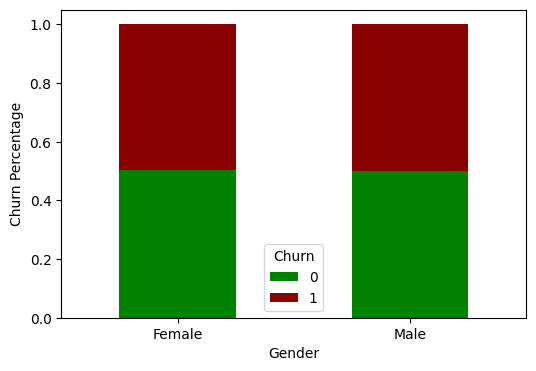

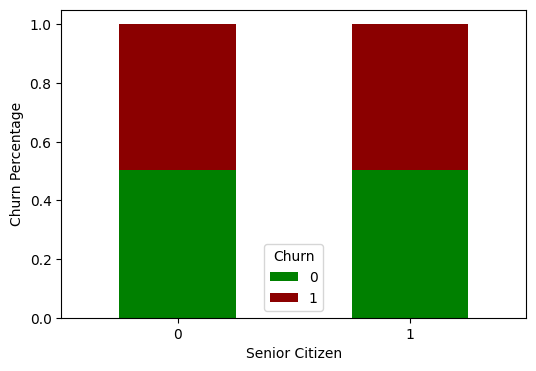

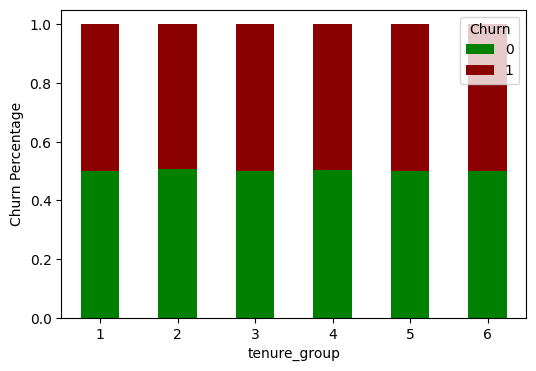

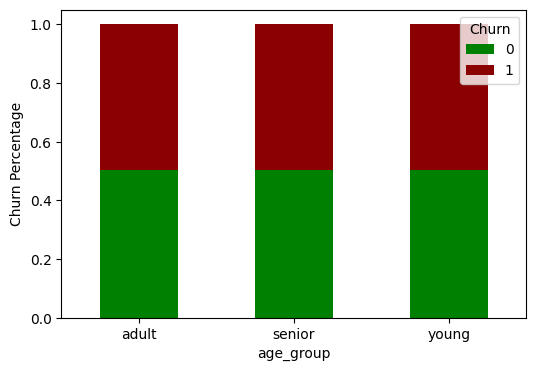

In [25]:
stacked_plot(customers_df, "Gender", "Churn")
stacked_plot(customers_df, "Senior Citizen", "Churn")
stacked_plot(customers_df, "tenure_group", "Churn")
stacked_plot(customers_df, "age_group", "Churn")

## From the stacked plot we can see that the churn is 50 percent for the features present the features generated. 

### In the next step the dataframe is split into two dataframes namely continuous variable dataframe and categorical variable dataframe.
### Continuous variable dataframe will be checked for multicollinearity and kind of distribution each variable has. Based on the distribution either normalization or the standardization will be applied.
### Categorical variable dataframe will undergo one hot encoder and label encoder for the categorical variables.
### These dataframes will be mearged after these pre processing steps.

## Splitting of dataframe.

In [30]:
customers_df.head(2)

Age  Gender     Location  Subscription_Length_Months  Monthly_Bill  \
0   63    Male  Los Angeles                          17         73.36   
1   62  Female     New York                           1         48.76   

   Total_Usage_GB  Churn  Senior Citizen  Total_Bill  tenure_group age_group  \
0             236      0               1     1247.12             5    senior   
1             172      0               1       48.76             1    senior   

   Bill_Ratio  
0    3.217012  
1    3.527482

In [31]:
# Dataframe to check the outliers for the continuous variable.

cont_var_df = customers_df[['Age', 'Subscription_Length_Months', 'Monthly_Bill', 'Total_Usage_GB','Total_Bill', 'Bill_Ratio']]
cat_var_df = customers_df[["Gender", "Location", 'Churn','Senior Citizen', 'tenure_group', 'age_group']]

### Pre-processing of continuous variable dataframe.

### Checking for outliers 

### Using Box Plot to detect the outliers

Indices of outliers from the box plots:
[24578, 57349, 40966, 40967, 16395, 32779, 57355, 98322, 16403, 24605, 40992, 49186, 73765, 57394, 81970, 98358, 98359, 65593, 90171, 32827, 16448, 49220, 65604, 70, 41035, 98381, 73809, 41059, 100, 57443, 65638, 103, 73829, 41065, 16496, 82035, 73844, 90229, 49273, 65657, 98426, 41086, 16511, 32898, 24708, 49286, 32905, 41097, 57481, 49298, 49302, 32919, 8343, 73886, 65695, 162, 24739, 57506, 98469, 16552, 65704, 49322, 175, 73905, 65716, 41145, 90303, 24769, 98500, 8390, 204, 16592, 57552, 24787, 82132, 49368, 82140, 220, 41182, 73949, 90335, 32993, 234, 98539, 57580, 16623, 240, 16626, 98549, 33015, 8440, 57593, 82169, 41211, 49403, 49404, 49406, 57598, 65790, 73985, 98563, 16644, 82180, 90374, 8459, 268, 8462, 98575, 82201, 65820, 49440, 8482, 57634, 33060, 16677, 82214, 57639, 90410, 24875, 65838, 90415, 90416, 74033, 65842, 307, 8501, 49469, 57662, 98622, 74050, 24900, 82246, 57675, 82258, 16723, 24915, 33112, 65880, 49498, 41307, 74073, 82

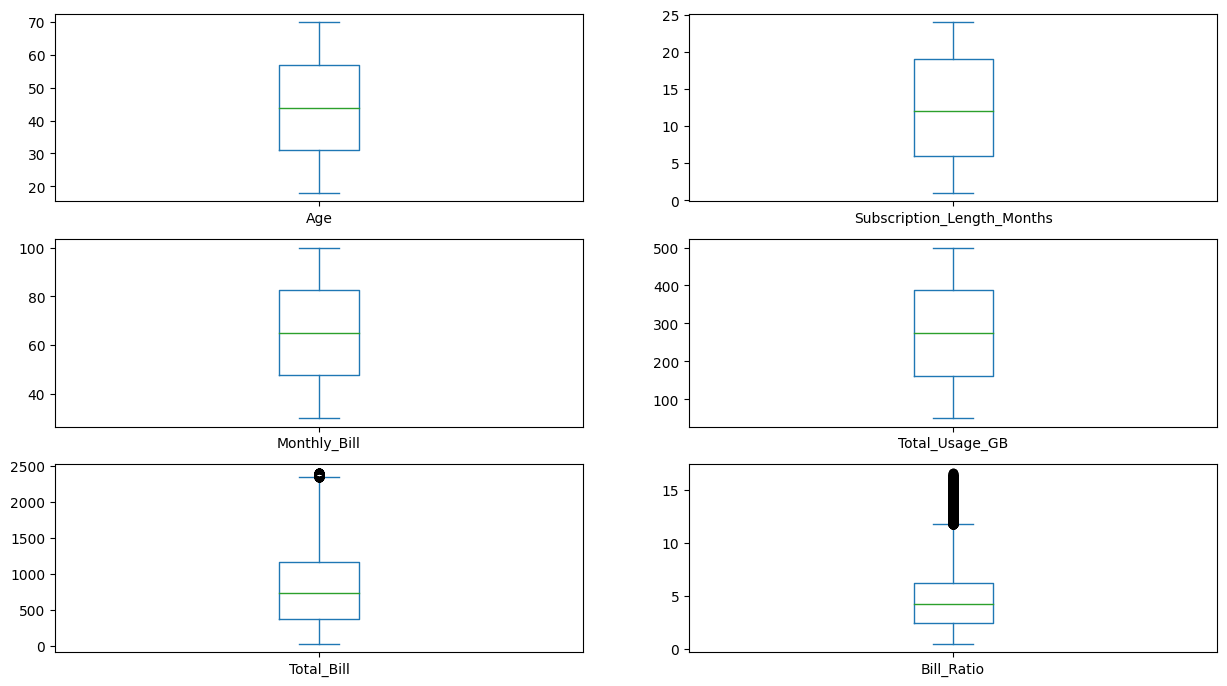

In [32]:
# Box plot find the outliers 

box_plot = cont_var_df.plot(kind="box",subplots=True,layout=(7,2),figsize=(15,20));

# Calculate the IQR for each variable
Q1 = cont_var_df.quantile(0.25)
Q3 = cont_var_df.quantile(0.75)
IQR = Q3 - Q1

# Set the IQR multiplier for identifying potential outliers
IQR_multiplier = 1.5  # Adjust as needed

# Get the indices of the outliers
outlier_indices = []

for col, ax in zip(cont_var_df.columns, box_plot):
    outliers = ((cont_var_df[col] < (Q1[col] - IQR_multiplier * IQR[col])) | (cont_var_df[col] > (Q3[col] + IQR_multiplier * IQR[col])))
    col_outlier_indices = cont_var_df.index[outliers]
    outlier_indices.extend(col_outlier_indices)

outlier_indices = list(set(outlier_indices))  # Remove duplicate indices

# Display the outlier indices
print("Indices of outliers from the box plots:")
print(outlier_indices)
print(len(outlier_indices))

### Using IQR to detect the outliers 

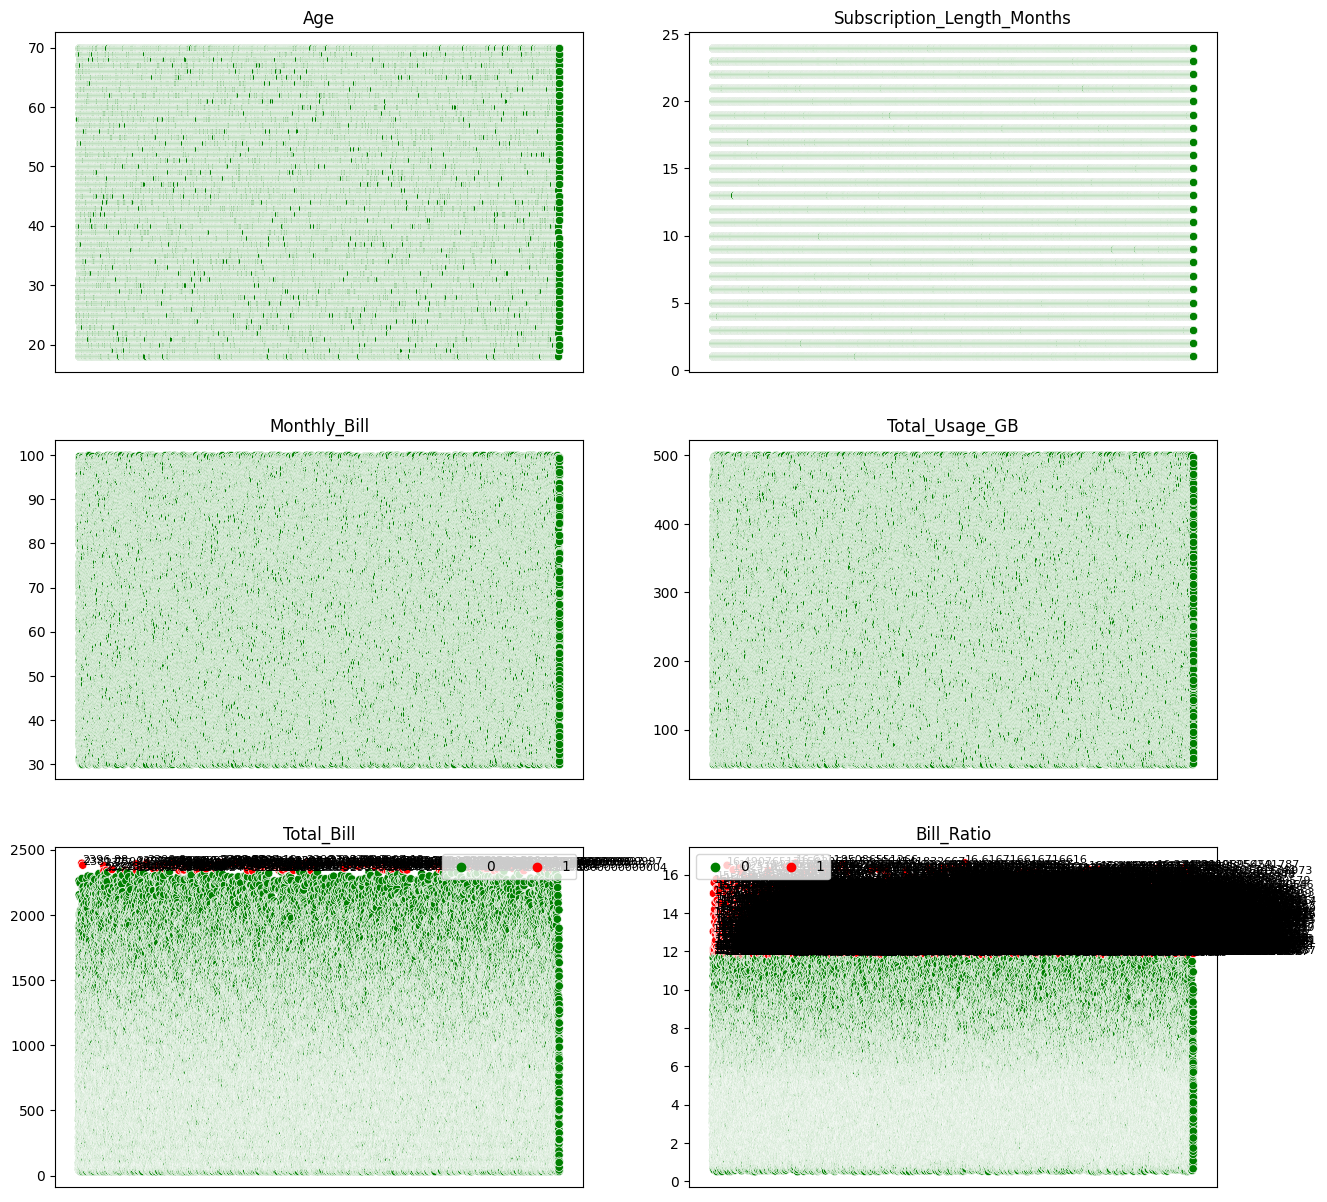

Row indices of potential outliers:
Int64Index([   70,   100,   103,   162,   175,   204,   220,   234,   240,
              268,
            ...
            99856, 99870, 99884, 99922, 99923, 99950, 99961, 99963, 99970,
            99990],
           dtype='int64', length=3053)


In [34]:
#FUNCTION TO IDENTIFY OUTLIERS USING IQR METHOD
def iqr_outlier(x,factor):
    q1 = x.quantile(0.25)
    q3 = x.quantile(0.75)
    iqr = q3 - q1
    min_ = q1 - factor * iqr
    max_ = q3 + factor * iqr
    result_ = pd.Series([0] * len(x))
    result_[((x < min_) | (x > max_))] = 1
    return result_
#SCATTER PLOTS HIGHLIGHTING OUTLIERS CALCULATED USING IQR METHOD
fig, ax = plt.subplots(3, 2, figsize=(15, 15))
row = col = 0
for n,i in enumerate(cont_var_df.columns):
    if (n % 2 == 0) & (n > 0):
        row += 1
        col = 0
    outliers = iqr_outlier(cont_var_df[i], 1.5)
   
   
    if sum(outliers) == 0:
        sns.scatterplot(x = np.arange(len(cont_var_df[i])), y = cont_var_df[i], ax = ax[row, col], legend=False, color = 'green')
    else:
        sns.scatterplot(x = np.arange(len(cont_var_df[i])), y = cont_var_df[i], ax = ax[row, col], hue = outliers, palette = ['green','red'])
    for x,y in zip(np.arange(len(cont_var_df[i]))[outliers == 1], cont_var_df[i][outliers == 1]):
        ax[row,col].text(x = x, y = y, s = y, fontsize = 8)
    ax[row,col].set_ylabel("")
    ax[row,col].set_title(i)
    ax[row,col].xaxis.set_visible(False)
    if sum(outliers) > 0:
        ax[row,col].legend(ncol=2)
    col += 1
plt.show()

# Calculate the IQR for each variable
Q1 = cont_var_df.quantile(0.25)
Q3 = cont_var_df.quantile(0.75)
IQR = Q3 - Q1

# Set the IQR multiplier for identifying potential outliers
IQR_multiplier = 1.5  # Adjust as needed

# Identify potential outliers based on the IQR method
outliers = ((cont_var_df < (Q1 - IQR_multiplier * IQR)) | (cont_var_df > (Q3 + IQR_multiplier * IQR)))

# Get the row indices of potential outliers
row_indices = cont_var_df.index[outliers.any(axis=1)]

# Print the row indices of potential outliers
print("Row indices of potential outliers:")
print(row_indices)

### Using Z-Scores to detect the outliers 

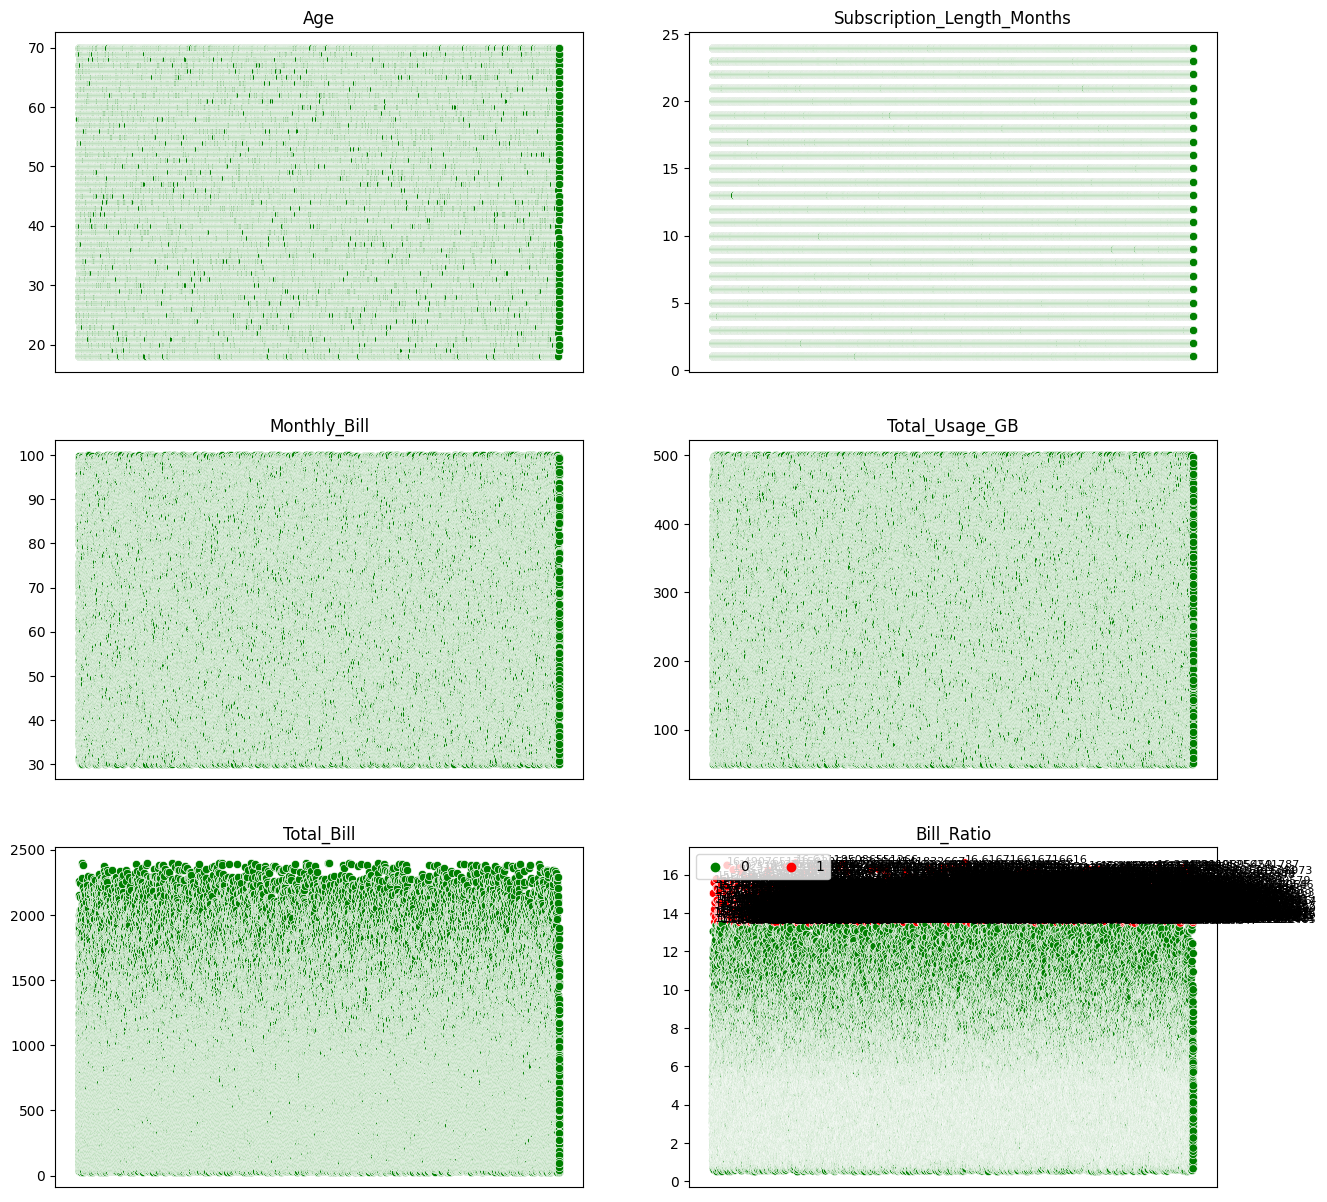

In [37]:
#FUNCTION TO DETECT OUTLIERS USING Z-SCORE METHOD
def zscore_outlier(x,lb,ub):
    zscore = ((x - x.mean()) / x.std()).copy()
    result_ = pd.Series([0] * len(x))
    result_[((zscore < lb) | (zscore > ub))] = 1
    return result_
#PLOTTING A SCATTER PLOT AND HIGHLIGHTING THE OUTLIERS DETECTED BY Z-SCORE METHOD
fig, ax = plt.subplots(3, 2, figsize=(15, 15))
row = col = 0
for n,i in enumerate(cont_var_df.columns):
    if (n % 2 == 0) & (n > 0):
        row += 1
        col = 0
    outliers = zscore_outlier(cont_var_df[i], -3, 3)
   
    if sum(outliers) == 0:
        sns.scatterplot(x = np.arange(len(cont_var_df[i])), y = cont_var_df[i], ax = ax[row, col], legend=False, color = 'green')
    else:
        sns.scatterplot(x = np.arange(len(cont_var_df[i])), y = cont_var_df[i], ax = ax[row, col], hue = outliers, palette = ['green','red'])
    for x,y in zip(np.arange(len(cont_var_df[i]))[outliers == 1], cont_var_df[i][outliers == 1]):
        ax[row,col].text(x = x, y = y, s = y, fontsize = 8)
    ax[row,col].set_ylabel("")
    ax[row,col].set_title(i)
    ax[row,col].xaxis.set_visible(False)
    if sum(outliers) > 0:
        ax[row,col].legend(ncol=2)
    col += 1

plt.show()


### From the above methods we see some outliers but the outliers are within the buiness range hence no need of removing of the outliers. 

### Correlation matrix

In [40]:
# Correlation matrix to check the multi collinearity of the features
cont_var_df.corr()

Age  Subscription_Length_Months  \
Age                         1.000000                    0.003382   
Subscription_Length_Months  0.003382                    1.000000   
Monthly_Bill                0.001110                   -0.005294   
Total_Usage_GB              0.001927                   -0.002203   
Total_Bill                  0.004375                    0.841891   
Bill_Ratio                  0.001804                   -0.000317   

                            Monthly_Bill  Total_Usage_GB  Total_Bill  \
Age                             0.001110        0.001927    0.004375   
Subscription_Length_Months     -0.005294       -0.002203    0.841891   
Monthly_Bill                    1.000000        0.003187    0.466938   
Total_Usage_GB                  0.003187        1.000000    0.000199   
Total_Bill                      0.466938        0.000199    1.000000   
Bill_Ratio                     -0.547734        0.768990   -0.258282   

                            Bill_Ratio  
Age                           0.001804  
Subscription_Length_Months   -0.000317  
Monthly_Bill                 -0.547734  
Total_Usage_GB                0.768990  
Total_Bill                   -0.258282  
Bill_Ratio                    1.000000

### None of the value is near or equal to 1 or -1 for the continuous features. Hence no multicolinearity present.

### Calculating VIF for each variable 

In [41]:
import pandas as pd
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Calculate VIF for each feature
def calculate_vif(data_frame):
    vif_data = pd.DataFrame()
    vif_data["feature"] = data_frame.columns
    vif_data["VIF"] = [variance_inflation_factor(data_frame.values, i) for i in range(data_frame.shape[1])]
    return vif_data

vif_results = calculate_vif(cont_var_df)  
print("VIF Results:")
print(vif_results)

VIF Results:
                      feature        VIF
0                         Age   8.450087
1  Subscription_Length_Months  28.526538
2                Monthly_Bill  15.042990
3              Total_Usage_GB  28.926692
4                  Total_Bill  30.222107
5                  Bill_Ratio  23.070332


### VIF value for all the features is very low. Hence all the variables are significant and there is no presence of multicollinearity.
### From both the correlation matrix and the VIF value show that none of the feature depend on each other. Hence there is no multicollinearity present in the dataset. 

## Checking the distribution of the continuous variable data 

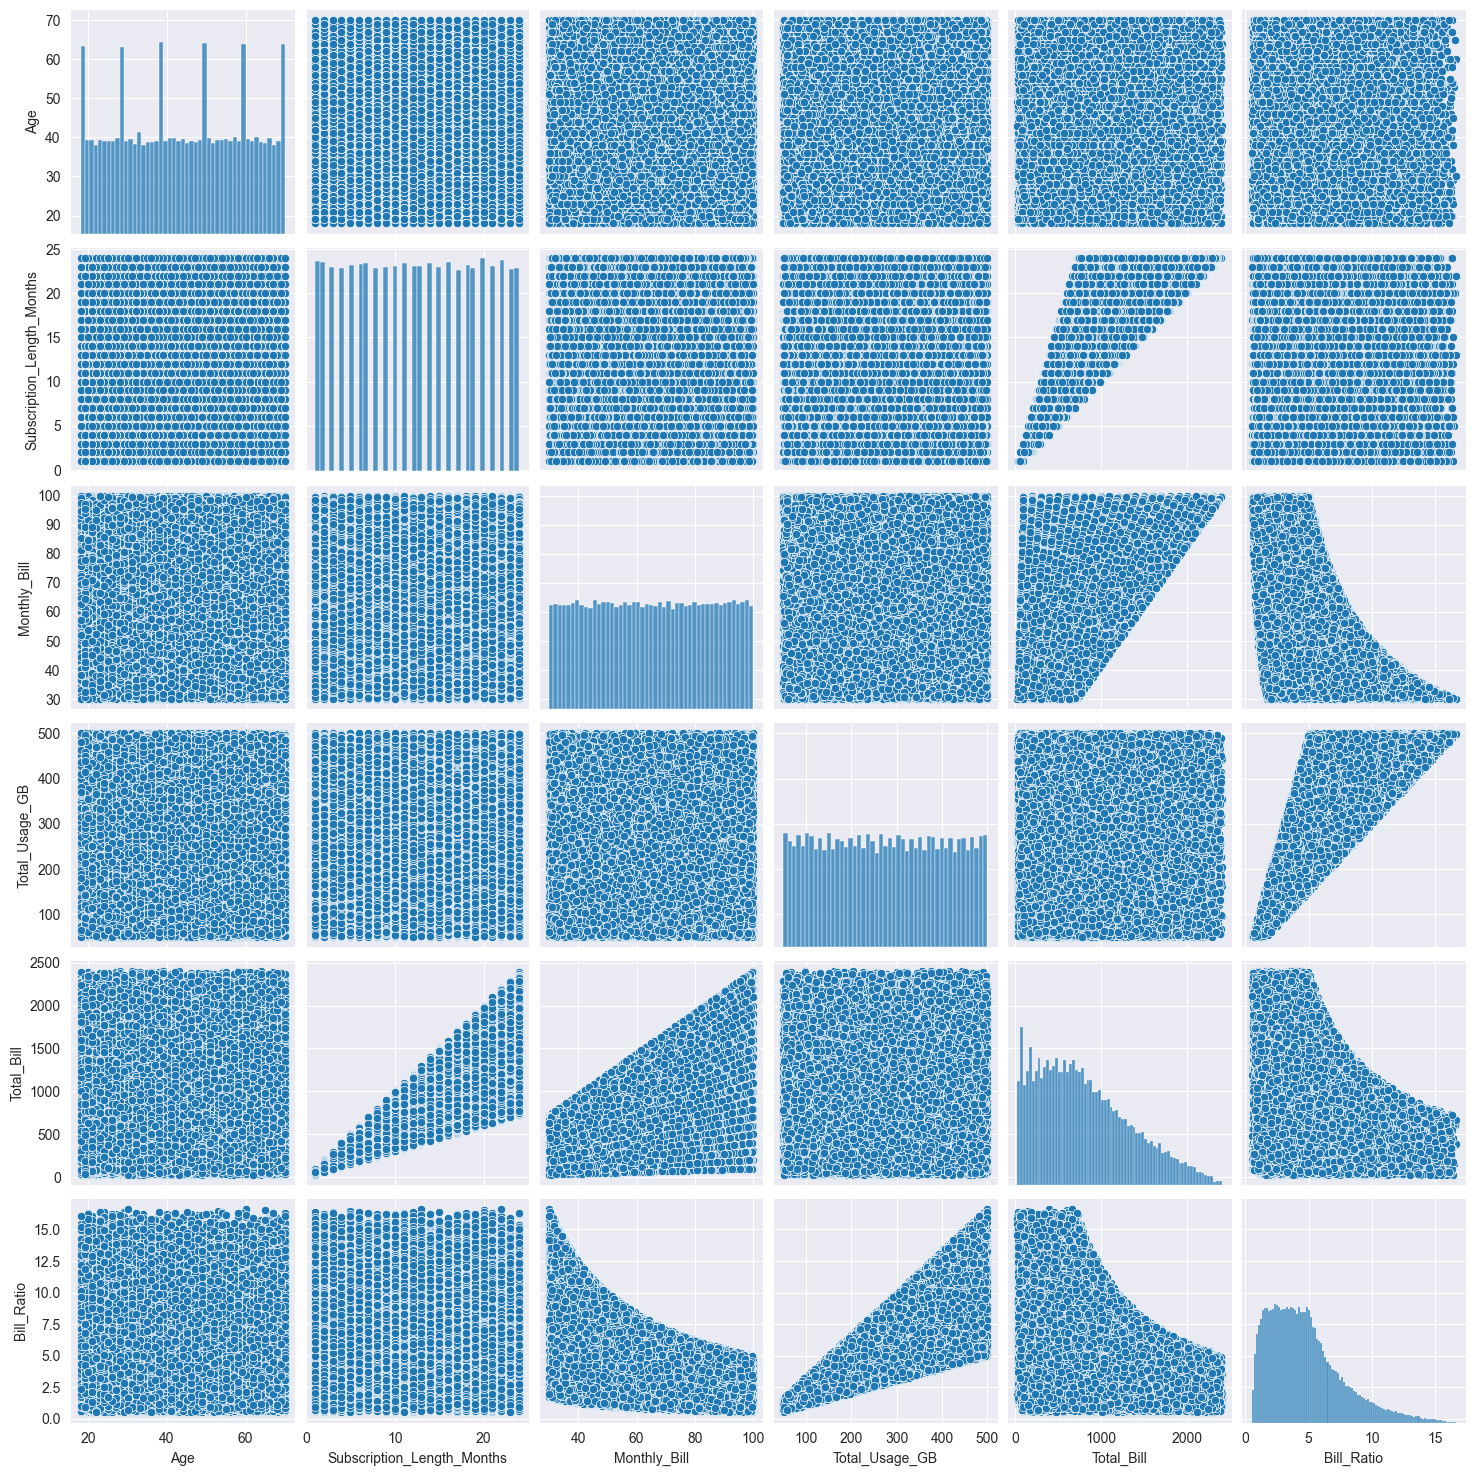

In [42]:
# Drawing Histogram to check the distribution of the data.
#Format the plot background and scatter plots for all the variables
sns.set_style(style='darkgrid')
sns.pairplot(cont_var_df)

### Most of the histogram shows that the features are not normally distributed.

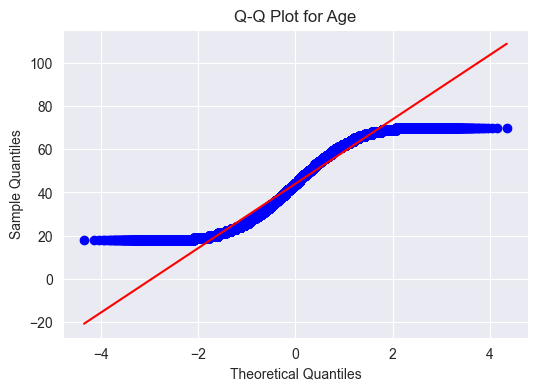

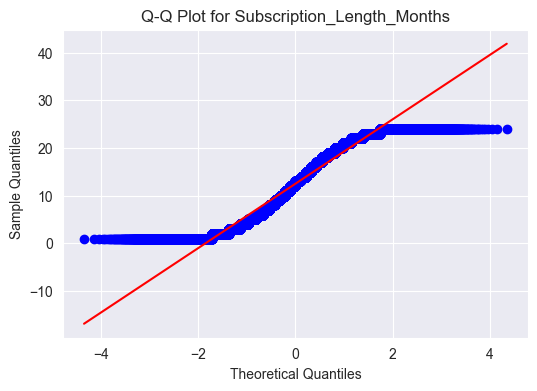

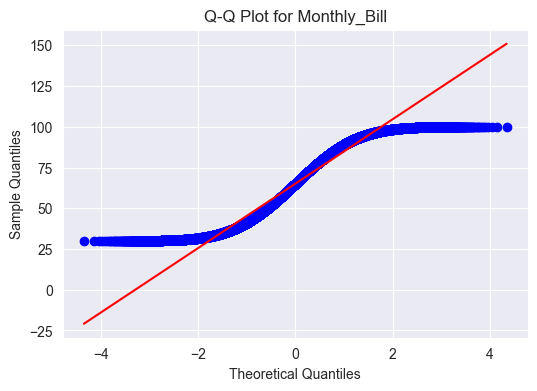

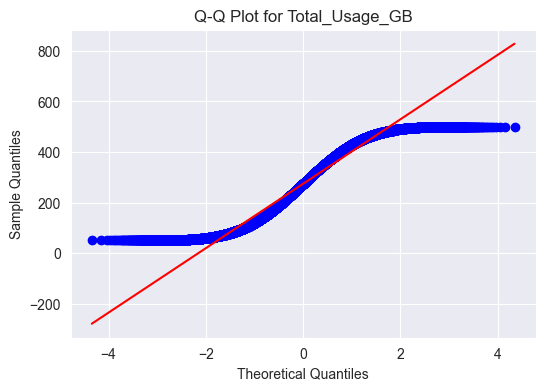

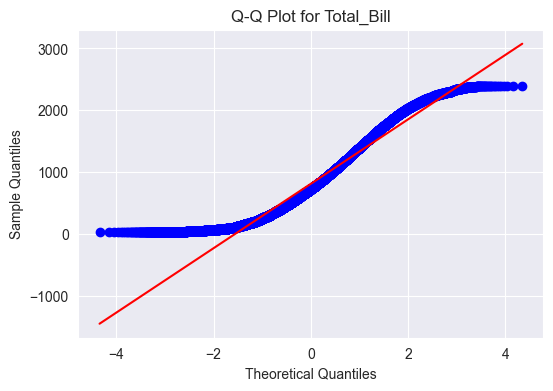

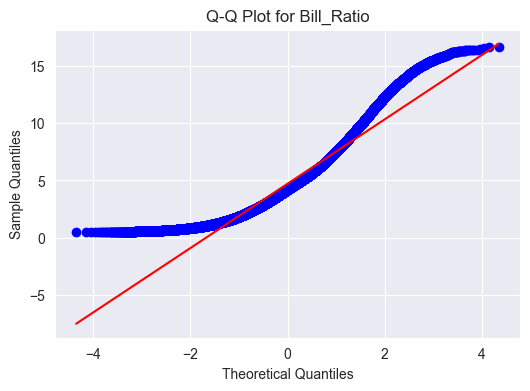

In [43]:
# Using Q-Q plot for checking the data distribution
# Create Q-Q plots for each variable in separate graphs
for col in cont_var_df.columns:
    plt.figure(figsize=(6, 4))
    stats.probplot(cont_var_df[col], dist="norm", plot=plt)
    plt.title(f"Q-Q Plot for {col}")
    plt.xlabel("Theoretical Quantiles")
    plt.ylabel("Sample Quantiles")
    plt.grid(True)
    plt.show()

### Most of the Q-Q plot shows that features are not normally distributed.

### Hence we can use Normalization for transformation.

### Normalizing the dataframe 

In [44]:
from sklearn.preprocessing import MinMaxScaler

# Initialize the Normalization
min_max_scaler = MinMaxScaler()

# Fit and transform the data using standardization
normalized_data_minmax = min_max_scaler.fit_transform(cont_var_df)


# Create a new DataFrame with the standardized data
normalized_df = pd.DataFrame(normalized_data_minmax, columns = cont_var_df.columns)

In [45]:
normalized_df.head(5)

Age  Subscription_Length_Months  Monthly_Bill  Total_Usage_GB  \
0  0.865385                    0.695652      0.619429        0.413333   
1  0.846154                    0.000000      0.268000        0.271111   
2  0.115385                    0.173913      0.792429        0.911111   
3  0.346154                    0.086957      0.970571        0.548889   
4  0.538462                    0.782609      0.402000        0.480000   

   Total_Bill  Bill_Ratio  
0    0.513644    0.168573  
1    0.007892    0.187837  
2    0.167671    0.302907  
3    0.111317    0.157123  
4    0.453521    0.252844

### Standardizing the dataframe

In [46]:
from sklearn.preprocessing import StandardScaler

# Initialize the Standardization
scaler = StandardScaler()

# Fit and transform the data using standardization
standardized_data_minmax = scaler.fit_transform(cont_var_df)

# Create a new DataFrame with the standardized data
standard_df = pd.DataFrame(standardized_data_minmax, columns = cont_var_df.columns)

In [47]:
standard_df.head(5)

Age  Subscription_Length_Months  Monthly_Bill  Total_Usage_GB  \
0  1.241670                    0.651115      0.410606       -0.294289   
1  1.176226                   -1.658879     -0.805374       -0.784852   
2 -1.310651                   -1.081380      1.009204        1.422681   
3 -0.525321                   -1.370129      1.625597        0.173279   
4  0.129120                    0.939864     -0.341720       -0.064338   

   Total_Bill  Bill_Ratio  
0    0.815465   -0.514146  
1   -1.429260   -0.407508  
2   -0.720099    0.229471  
3   -0.970222   -0.577532  
4    0.548614   -0.047657

### Pre-processing of Categorical variable dataframe.

In [48]:
cat_var_df.head(5)

Gender     Location  Churn  Senior Citizen  tenure_group age_group
0    Male  Los Angeles      0               1             5    senior
1  Female     New York      0               1             1    senior
2  Female  Los Angeles      0               0             2     adult
3  Female        Miami      1               0             1     adult
4  Female        Miami      0               0             5     adult

### Unique categories in each column of categorical variable dataframe 

In [49]:
# Iterate through columns and print unique values
for column in cat_var_df.columns:
    unique_values = cat_var_df[column].unique()
    print(f'Unique values in {column}: {unique_values}')

Unique values in Gender: ['Male' 'Female']
Unique values in Location: ['Los Angeles' 'New York' 'Miami' 'Chicago' 'Houston']
Unique values in Churn: [0 1]
Unique values in Senior Citizen: [1 0]
Unique values in tenure_group: [5 1 2 4 3 6]
Unique values in age_group: ['senior' 'adult' 'young']


### Applying Label encoder to Gender column as it has only two categories.

In [50]:
from sklearn.preprocessing import LabelEncoder

# Initialize LabelEncoder
encoder = LabelEncoder()

# Fit and transform the dataset
encoded_labels = encoder.fit_transform(cat_var_df["Gender"])

# Add encoded labels to the DataFrame
cat_var_df["Gender"] = encoded_labels

In [51]:
cat_var_df.head(5)

Gender     Location  Churn  Senior Citizen  tenure_group age_group
0       1  Los Angeles      0               1             5    senior
1       0     New York      0               1             1    senior
2       0  Los Angeles      0               0             2     adult
3       0        Miami      1               0             1     adult
4       0        Miami      0               0             5     adult

### Applying one hot encoder to location column and dropping one column after one hot encoding to avoid dummy variable trap or multicollinearity . 

In [52]:
from sklearn.preprocessing import OneHotEncoder

# Initialize OneHotEncoder and drop one of the column to avoid dummy variable trap or perfect multicollinearity
encoder = OneHotEncoder(drop="first")

# Fit and transform the dataset
encoded_features = encoder.fit_transform(cat_var_df[["Location"]]).toarray()

# Create a new DataFrame with the encoded features
encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(["Location"]))

# Drop the original categorical column from the main DataFrame
cat_var_df = cat_var_df.drop(columns=["Location"])

# Concatenate the original DataFrame and the encoded DataFrame
cat_var_df = pd.concat([cat_var_df, encoded_df], axis=1)

In [53]:
cat_var_df.head(5)

Gender  Churn  Senior Citizen  tenure_group age_group  Location_Houston  \
0       1      0               1             5    senior               0.0   
1       0      0               1             1    senior               0.0   
2       0      0               0             2     adult               0.0   
3       0      1               0             1     adult               0.0   
4       0      0               0             5     adult               0.0   

   Location_Los Angeles  Location_Miami  Location_New York  
0                   1.0             0.0                0.0  
1                   0.0             0.0                1.0  
2                   1.0             0.0                0.0  
3                   0.0             1.0                0.0  
4                   0.0             1.0                0.0

### Applying one hot encoder to tenure column and dropping one column after one hot encoding to avoid dummy variable trap or multicollinearity .

In [54]:
from sklearn.preprocessing import OneHotEncoder

# Initialize OneHotEncoder and drop one of the column to avoid dummy variable trap or perfect multicollinearity
encoder = OneHotEncoder(drop="first")

# Fit and transform the dataset
encoded_features = encoder.fit_transform(cat_var_df[["tenure_group"]]).toarray()

# Create a new DataFrame with the encoded features
encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(["tenure_group"]))

# Drop the original categorical column from the main DataFrame
cat_var_df = cat_var_df.drop(columns=["tenure_group"])

# Concatenate the original DataFrame and the encoded DataFrame
cat_var_df = pd.concat([cat_var_df, encoded_df], axis=1)

In [55]:
cat_var_df.head(5)

Gender  Churn  Senior Citizen age_group  Location_Houston  \
0       1      0               1    senior               0.0   
1       0      0               1    senior               0.0   
2       0      0               0     adult               0.0   
3       0      1               0     adult               0.0   
4       0      0               0     adult               0.0   

   Location_Los Angeles  Location_Miami  Location_New York  tenure_group_2  \
0                   1.0             0.0                0.0             0.0   
1                   0.0             0.0                1.0             0.0   
2                   1.0             0.0                0.0             1.0   
3                   0.0             1.0                0.0             0.0   
4                   0.0             1.0                0.0             0.0   

   tenure_group_3  tenure_group_4  tenure_group_5  tenure_group_6  
0             0.0             0.0             1.0             0.0  
1             0.0             0.0             0.0             0.0  
2             0.0             0.0             0.0             0.0  
3             0.0             0.0             0.0             0.0  
4             0.0             0.0             1.0             0.0

### Applying one hot encoder to tenure column and dropping one column after one hot encoding to avoid dummy variable trap or multicollinearity .

In [56]:
from sklearn.preprocessing import OneHotEncoder

# Initialize OneHotEncoder and drop one of the column to avoid dummy variable trap or perfect multicollinearity
encoder = OneHotEncoder(drop="first")

# Fit and transform the dataset
encoded_features = encoder.fit_transform(cat_var_df[["age_group"]]).toarray()

# Create a new DataFrame with the encoded features
encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(["age_group"]))

# Drop the original categorical column from the main DataFrame
cat_var_df = cat_var_df.drop(columns=["age_group"])

# Concatenate the original DataFrame and the encoded DataFrame
cat_var_df = pd.concat([cat_var_df, encoded_df], axis=1)

In [57]:
cat_var_df.head(5)

Gender  Churn  Senior Citizen  Location_Houston  Location_Los Angeles  \
0       1      0               1               0.0                   1.0   
1       0      0               1               0.0                   0.0   
2       0      0               0               0.0                   1.0   
3       0      1               0               0.0                   0.0   
4       0      0               0               0.0                   0.0   

   Location_Miami  Location_New York  tenure_group_2  tenure_group_3  \
0             0.0                0.0             0.0             0.0   
1             0.0                1.0             0.0             0.0   
2             0.0                0.0             1.0             0.0   
3             1.0                0.0             0.0             0.0   
4             1.0                0.0             0.0             0.0   

   tenure_group_4  tenure_group_5  tenure_group_6  age_group_senior  \
0             0.0             1.0             0.0               1.0   
1             0.0             0.0             0.0               1.0   
2             0.0             0.0             0.0               0.0   
3             0.0             0.0             0.0               0.0   
4             0.0             1.0             0.0               0.0   

   age_group_young  
0              0.0  
1              0.0  
2              0.0  
3              0.0  
4              0.0

### Mearging normalized continuous variable dataframe and encoded dataframe. 

In [58]:
# Concatenate the normalized DataFrame and the encoded DataFrame
norm_final_df = pd.concat([normalized_df, cat_var_df], axis=1)

In [59]:
norm_final_df.head(5)

Age  Subscription_Length_Months  Monthly_Bill  Total_Usage_GB  \
0  0.865385                    0.695652      0.619429        0.413333   
1  0.846154                    0.000000      0.268000        0.271111   
2  0.115385                    0.173913      0.792429        0.911111   
3  0.346154                    0.086957      0.970571        0.548889   
4  0.538462                    0.782609      0.402000        0.480000   

   Total_Bill  Bill_Ratio  Gender  Churn  Senior Citizen  Location_Houston  \
0    0.513644    0.168573       1      0               1               0.0   
1    0.007892    0.187837       0      0               1               0.0   
2    0.167671    0.302907       0      0               0               0.0   
3    0.111317    0.157123       0      1               0               0.0   
4    0.453521    0.252844       0      0               0               0.0   

   Location_Los Angeles  Location_Miami  Location_New York  tenure_group_2  \
0                   1.0             0.0                0.0             0.0   
1                   0.0             0.0                1.0             0.0   
2                   1.0             0.0                0.0             1.0   
3                   0.0             1.0                0.0             0.0   
4                   0.0             1.0                0.0             0.0   

   tenure_group_3  tenure_group_4  tenure_group_5  tenure_group_6  \
0             0.0             0.0             1.0             0.0   
1             0.0             0.0             0.0             0.0   
2             0.0             0.0             0.0             0.0   
3             0.0             0.0             0.0             0.0   
4             0.0             0.0             1.0             0.0   

   age_group_senior  age_group_young  
0               1.0              0.0  
1               1.0              0.0  
2               0.0              0.0  
3               0.0              0.0  
4               0.0              0.0

### Mearging original continuous variable dataframe and encoded dataframe.

In [60]:
# Concatenate the original DataFrame and the encoded DataFrame
org_final_df = pd.concat([cont_var_df, cat_var_df], axis=1)

In [61]:
org_final_df.head(5)

Age  Subscription_Length_Months  Monthly_Bill  Total_Usage_GB  Total_Bill  \
0   63                          17         73.36             236     1247.12   
1   62                           1         48.76             172       48.76   
2   24                           5         85.47             460      427.35   
3   36                           3         97.94             297      293.82   
4   46                          19         58.14             266     1104.66   

   Bill_Ratio  Gender  Churn  Senior Citizen  Location_Houston  \
0    3.217012       1      0               1               0.0   
1    3.527482       0      0               1               0.0   
2    5.382005       0      0               0               0.0   
3    3.032469       0      1               0               0.0   
4    4.575163       0      0               0               0.0   

   Location_Los Angeles  Location_Miami  Location_New York  tenure_group_2  \
0                   1.0             0.0                0.0             0.0   
1                   0.0             0.0                1.0             0.0   
2                   1.0             0.0                0.0             1.0   
3                   0.0             1.0                0.0             0.0   
4                   0.0             1.0                0.0             0.0   

   tenure_group_3  tenure_group_4  tenure_group_5  tenure_group_6  \
0             0.0             0.0             1.0             0.0   
1             0.0             0.0             0.0             0.0   
2             0.0             0.0             0.0             0.0   
3             0.0             0.0             0.0             0.0   
4             0.0             0.0             1.0             0.0   

   age_group_senior  age_group_young  
0               1.0              0.0  
1               1.0              0.0  
2               0.0              0.0  
3               0.0              0.0  
4               0.0              0.0

### Mearging standardized continuous variable dataframe and encoded dataframe.

In [62]:
# Concatenate the standardized DataFrame and the encoded DataFrame
stnd_final_df = pd.concat([standard_df, cat_var_df], axis=1)

In [63]:
stnd_final_df.head(5)

Age  Subscription_Length_Months  Monthly_Bill  Total_Usage_GB  \
0  1.241670                    0.651115      0.410606       -0.294289   
1  1.176226                   -1.658879     -0.805374       -0.784852   
2 -1.310651                   -1.081380      1.009204        1.422681   
3 -0.525321                   -1.370129      1.625597        0.173279   
4  0.129120                    0.939864     -0.341720       -0.064338   

   Total_Bill  Bill_Ratio  Gender  Churn  Senior Citizen  Location_Houston  \
0    0.815465   -0.514146       1      0               1               0.0   
1   -1.429260   -0.407508       0      0               1               0.0   
2   -0.720099    0.229471       0      0               0               0.0   
3   -0.970222   -0.577532       0      1               0               0.0   
4    0.548614   -0.047657       0      0               0               0.0   

   Location_Los Angeles  Location_Miami  Location_New York  tenure_group_2  \
0                   1.0             0.0                0.0             0.0   
1                   0.0             0.0                1.0             0.0   
2                   1.0             0.0                0.0             1.0   
3                   0.0             1.0                0.0             0.0   
4                   0.0             1.0                0.0             0.0   

   tenure_group_3  tenure_group_4  tenure_group_5  tenure_group_6  \
0             0.0             0.0             1.0             0.0   
1             0.0             0.0             0.0             0.0   
2             0.0             0.0             0.0             0.0   
3             0.0             0.0             0.0             0.0   
4             0.0             0.0             1.0             0.0   

   age_group_senior  age_group_young  
0               1.0              0.0  
1               1.0              0.0  
2               0.0              0.0  
3               0.0              0.0  
4               0.0              0.0

# Model building

### Model building on normalized dataset.

In [109]:
# Split the dataset into features (X) and target (y)
X = stnd_final_df.drop("Churn", axis=1)
y = stnd_final_df["Churn"]

In [119]:
# Importing train - test split , K-fold Cross validation and accuracy score and classification report 

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import StratifiedKFold, cross_val_score

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize an empty DataFrame to store the results
Results_DF = pd.DataFrame(columns=["Model", "Accuracy"])

'# Initialize an empty DataFrame to store the results\nResults_DF = pd.DataFrame(columns=["Model", "Accuracy"])'

In [113]:
from sklearn.linear_model import LogisticRegression

# Train and evaluate the first model (Logistic Regression)
model_name = "Logistic Regression"

# Train a logistic regression classifier
log_classifier = LogisticRegression()
log_classifier.fit(X_train, y_train)

# Predict sentiment on the test data
y_pred = log_classifier.predict(X_test)

# Evaluate the model
accuracy1 = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

classification_rep = classification_report(y_test, y_pred)
print("Classification Report:")
print(classification_rep)

# Add the results to the DataFrame
Results_DF = Results_DF.append({"Model": model_name, "Accuracy": accuracy1}, ignore_index=True)

Accuracy: 0.51
Classification Report:
              precision    recall  f1-score   support

           0       0.51      0.61      0.55     10079
           1       0.50      0.39      0.44      9921

    accuracy                           0.50     20000
   macro avg       0.50      0.50      0.50     20000
weighted avg       0.50      0.50      0.50     20000



'# Add the results to the DataFrame\nResults_DF = Results_DF.append({"Model": model_name, "Accuracy": accuracy1}, ignore_index=True)'

In [114]:
from sklearn.tree import DecisionTreeClassifier

# Train and evaluate the first model (Logistic Regression)
model_name = "Decision Tree Classifier"

# Initialize the Decision Tree Classifier
dt_classifier = DecisionTreeClassifier(random_state=42)

# Train the classifier on the training data
dt_classifier.fit(X_train, y_train)

# Predict the labels for the test data
y_pred = dt_classifier.predict(X_test)

# Evaluate the model
accuracy2 = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print("Accuracy:", accuracy)
print("Classification Report:")
print(classification_rep)

# Add the results to the DataFrame
Results_DF = Results_DF.append({"Model": model_name, "Accuracy": accuracy2}, ignore_index=True)

Accuracy: 0.5056
Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.50      0.50     10079
           1       0.49      0.50      0.50      9921

    accuracy                           0.50     20000
   macro avg       0.50      0.50      0.50     20000
weighted avg       0.50      0.50      0.50     20000



'# Add the results to the DataFrame\nResults_DF = Results_DF.append({"Model": model_name, "Accuracy": accuracy2}, ignore_index=True)'

In [115]:
from sklearn.tree import DecisionTreeClassifier

# Train and evaluate the first model (Logistic Regression)
model_name = "Decision Tree Classifier"

# Initialize the Decision Tree Classifier
dt_classifier = DecisionTreeClassifier(random_state=42)

# Train the classifier on the training data
dt_classifier.fit(X_train, y_train)

# Predict the labels for the test data
y_pred = dt_classifier.predict(X_test)

# Evaluate the model
accuracy2 = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print("Accuracy:", accuracy)
print("Classification Report:")
print(classification_rep)

# Add the results to the DataFrame
Results_DF = Results_DF.append({"Model": model_name, "Accuracy": accuracy2}, ignore_index=True)

Accuracy: 0.5056
Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.50      0.50     10079
           1       0.49      0.50      0.50      9921

    accuracy                           0.50     20000
   macro avg       0.50      0.50      0.50     20000
weighted avg       0.50      0.50      0.50     20000



In [116]:
from sklearn.ensemble import RandomForestClassifier

# Train and evaluate the first model (Logistic Regression)
model_name = "Random Forest Classifier"

# Initialize the Random Forest Classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the classifier on the training data
rf_classifier.fit(X_train, y_train)

# Predict the labels for the test data
y_pred = rf_classifier.predict(X_test)

# Evaluate the model
accuracy3 = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print("Accuracy:", accuracy)
print("Classification Report:")
print(classification_rep)

# Add the results to the DataFrame
Results_DF = Results_DF.append({"Model": model_name, "Accuracy": accuracy3}, ignore_index=True)

Accuracy: 0.5056
Classification Report:
              precision    recall  f1-score   support

           0       0.51      0.54      0.52     10079
           1       0.50      0.47      0.48      9921

    accuracy                           0.50     20000
   macro avg       0.50      0.50      0.50     20000
weighted avg       0.50      0.50      0.50     20000



In [95]:
from sklearn.svm import SVC

# Train and evaluate the first model (Logistic Regression)
model_name = "SVC"

# Initialize an SVM classifier (SVC)
classifier = SVC(kernel='sigmoid', C=1)

# Train the SVM classifier
classifier.fit(X_train, y_train)

# Predict sentiment on the test data
y_pred = classifier.predict(X_test)

# Evaluate the model
accuracy4 = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print("Accuracy:", accuracy)
print("Classification Report:")
print(classification_rep)

# Add the results to the DataFrame
Results_DF = Results_DF.append({"Model": model_name, "Accuracy": accuracy4}, ignore_index=True)

Accuracy: 0.5056
Classification Report:
              precision    recall  f1-score   support

           0       0.51      0.50      0.51     10079
           1       0.50      0.51      0.50      9921

    accuracy                           0.50     20000
   macro avg       0.50      0.50      0.50     20000
weighted avg       0.50      0.50      0.50     20000



In [96]:
from sklearn.neighbors import KNeighborsClassifier

# Train and evaluate the first model (Logistic Regression)
model_name = "K-Neighbors Classifier"

# Initialize the KNN Classifier with k=3 (you can adjust the value of k as needed)
knn_classifier = KNeighborsClassifier(n_neighbors=4)

# Train the classifier on the training data
knn_classifier.fit(X_train, y_train)

# Predict the labels for the test data
y_pred = knn_classifier.predict(X_test)

# Evaluate the model
accuracy5 = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print("Accuracy:", accuracy)
print("Classification Report:")
print(classification_rep)

# Add the results to the DataFrame
Results_DF = Results_DF.append({"Model": model_name, "Accuracy": accuracy5}, ignore_index=True)

Accuracy: 0.5056
Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.69      0.58     10079
           1       0.49      0.30      0.37      9921

    accuracy                           0.50     20000
   macro avg       0.50      0.50      0.48     20000
weighted avg       0.50      0.50      0.48     20000



In [97]:
from sklearn.naive_bayes import MultinomialNB

# Train and evaluate the first model (Logistic Regression)
model_name = "Multinomial Naive Bayes"

# Train a Multinomial Naive Bayes classifier
classifier = MultinomialNB()
classifier.fit(X_train, y_train)

# Predict sentiment on the test data
y_pred = classifier.predict(X_test)

# Evaluate the model
accuracy6 = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print("Accuracy:", accuracy)
print("Classification Report:")
print(classification_rep)

# Add the results to the DataFrame
Results_DF = Results_DF.append({"Model": model_name, "Accuracy": accuracy6}, ignore_index=True)

Accuracy: 0.5056
Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.52      0.51     10079
           1       0.50      0.48      0.49      9921

    accuracy                           0.50     20000
   macro avg       0.50      0.50      0.50     20000
weighted avg       0.50      0.50      0.50     20000



In [101]:
import xgboost as xgb

# Train and evaluate the first model (Logistic Regression)
model_name = "XGBM"

# Create an XGBoost classifier for classification
clf = xgb.XGBClassifier()  # For multi-class classification

# Fit the model on the training data
clf.fit(X_train, y_train)

# Make predictions on the test data
y_pred = clf.predict(X_test)

# Evaluate the model's accuracy
accuracy8 = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Optionally, print a classification report
print(classification_report(y_test, y_pred))

# Add the results to the DataFrame
Results_DF = Results_DF.append({"Model": model_name, "Accuracy": accuracy8}, ignore_index=True)

Accuracy: 0.51
              precision    recall  f1-score   support

           0       0.50      0.52      0.51     10079
           1       0.50      0.48      0.49      9921

    accuracy                           0.50     20000
   macro avg       0.50      0.50      0.50     20000
weighted avg       0.50      0.50      0.50     20000



In [107]:
import lightgbm as lgb

# Train and evaluate the first model (Logistic Regression)
model_name = "LGBM"

# Create a LightGBM classifier
clf = lgb.LGBMClassifier()

# Fit the model on the training data
clf.fit(X_train, y_train)

# Make predictions on the test data
y_pred = clf.predict(X_test)

# Evaluate the model's accuracy
accuracy9 = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Optionally, print a classification report
print(classification_report(y_test, y_pred))

# Add the results to the DataFrame
Results_DF = Results_DF.append({"Model": model_name, "Accuracy": accuracy9}, ignore_index=True)

Accuracy: 0.51
              precision    recall  f1-score   support

           0       0.50      0.56      0.53     10079
           1       0.49      0.43      0.46      9921

    accuracy                           0.50     20000
   macro avg       0.50      0.50      0.50     20000
weighted avg       0.50      0.50      0.50     20000



In [122]:
Results_DF

Model  Accuracy
0       Logistic Regression   0.50560
1  Decision Tree Classifier   0.49860
2  Random Forest Classifier   0.50255
3                       SVC   0.50475
4    K-Neighbors Classifier   0.49740
5   Multinomial Naive Bayes   0.49980
6                      XGBM   0.50010
7                      LGBM   0.49850

### From the above Models we can see that almost all the methods have the same accuracy. 
### But the recall value for KNN and Logistic regresion is 0.69 and 61. Hence we for the final model we use KNN for prediction.

In [123]:
from sklearn.neighbors import KNeighborsClassifier

# Train and evaluate the first model (Logistic Regression)
model_name = "K-Neighbors Classifier"

# Initialize the KNN Classifier with k=3 (you can adjust the value of k as needed)
final_model = KNeighborsClassifier(n_neighbors=4)

# Train the classifier on the training data
final_model.fit(X_train, y_train)

# Predict the labels for the test data
y_pred = final_model.predict(X_test)

# Evaluate the model
accuracy5 = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print("Accuracy:", accuracy)
print("Classification Report:")
print(classification_rep)

Accuracy: 0.5056
Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.69      0.58     10079
           1       0.50      0.31      0.38      9921

    accuracy                           0.50     20000
   macro avg       0.50      0.50      0.48     20000
weighted avg       0.50      0.50      0.48     20000



In [126]:
from sklearn.metrics import make_scorer, accuracy_score

# Initialize StratifiedKFold with k=5 (adjust as needed)
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Define a scoring function (e.g., accuracy) for cross-validation
scoring = make_scorer(accuracy_score)

# Initialize the KNN Classifier with k=3 (you can adjust the value of k as needed)
final_model = KNeighborsClassifier(n_neighbors=4)

# Perform k-fold cross-validation and get accuracy scores
cv_scores = cross_val_score(final_model, X, y, cv=kf, scoring=scoring)

# Print the accuracy scores for each fold
for i, score in enumerate(cv_scores, start=1):
    print(f"Fold {i}: {score:.2f}")
    

# Calculate and print the mean accuracy and standard deviation
mean_accuracy = cv_scores.mean()
std_deviation = cv_scores.std()
print(f"Mean Accuracy: {mean_accuracy:.2f}")
print(f"Standard Deviation: {std_deviation:.2f}")

Fold 1: 0.50
Fold 2: 0.50
Fold 3: 0.49
Fold 4: 0.50
Fold 5: 0.50
Mean Accuracy: 0.50
Standard Deviation: 0.00


### Applying Random Search CV for hyperparameter tuning

In [129]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_dist = {
    'n_neighbors': randint(1, 20),
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}

knn = KNeighborsClassifier()
random_search = RandomizedSearchCV(knn, param_distributions=param_dist, n_iter=10, cv=5)
random_search.fit(X_train, y_train)
best_params = random_search.best_params_

### Best hyperparameter values.

In [130]:
best_params

{'metric': 'manhattan', 'n_neighbors': 17, 'weights': 'uniform'}

# Final Model

In [133]:
from sklearn.neighbors import KNeighborsClassifier

# Train and evaluate the first model (Logistic Regression)
model_name = "K-Neighbors Classifier"

# Initialize the KNN Classifier with k=3 (you can adjust the value of k as needed)
final_model = KNeighborsClassifier(n_neighbors=5, weights='uniform', metric = 'manhattan')

# Train the classifier on the training data
final_model.fit(X_train, y_train)

# Predict the labels for the test data
y_pred = final_model.predict(X_test)

# Evaluate the model
accuracy5 = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print("Accuracy:", accuracy)
print("Classification Report:")
print(classification_rep)

Accuracy: 0.50185
Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.51      0.50     10079
           1       0.49      0.49      0.49      9921

    accuracy                           0.50     20000
   macro avg       0.50      0.50      0.50     20000
weighted avg       0.50      0.50      0.50     20000



In [134]:
import joblib

# Save the model to a file
joblib.dump(final_model, 'knn_model.pkl')

['knn_model.pkl']

# Building a neural network  

In [127]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report

In [128]:

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a Sequential neural network model
model = keras.Sequential([
    keras.layers.Input(shape=(X_train.shape[1],)),  # Input layer
    keras.layers.Dense(64, activation='relu'),      # Hidden layer with 64 units and ReLU activation
    keras.layers.Dense(1, activation='sigmoid')      # Output layer with 1 unit (binary classification) and sigmoid activation
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.1)

# Evaluate the model on the test data
y_pred = (model.predict(X_test) > 0.5).astype(int)

# Calculate accuracy and print classification report
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

print(classification_report(y_test, y_pred))

Epoch 1/10
2250/2250 [==============================] - 8s 2ms/step - loss: 0.6956 - accuracy: 0.4986 - val_loss: 0.6949 - val_accuracy: 0.4958
Epoch 2/10
2250/2250 [==============================] - 3s 1ms/step - loss: 0.6940 - accuracy: 0.5059 - val_loss: 0.6953 - val_accuracy: 0.4986
Epoch 3/10
2250/2250 [==============================] - 3s 1ms/step - loss: 0.6937 - accuracy: 0.5067 - val_loss: 0.6934 - val_accuracy: 0.4999
Epoch 4/10
2250/2250 [==============================] - 3s 1ms/step - loss: 0.6933 - accuracy: 0.5095 - val_loss: 0.6937 - val_accuracy: 0.5026
Epoch 5/10
2250/2250 [==============================] - 3s 1ms/step - loss: 0.6932 - accuracy: 0.5100 - val_loss: 0.6942 - val_accuracy: 0.5031
Epoch 6/10
2250/2250 [==============================] - 3s 1ms/step - loss: 0.6930 - accuracy: 0.5106 - val_loss: 0.6941 - val_accuracy: 0.5010
Epoch 7/10
2250/2250 [==============================] - 3s 2ms/step - loss: 0.6929 - accuracy: 0.5109 - val_loss: 0.6941 - val_accuracy:

### This neural network can be used as it shows greater recall than the machine learning models. 